# calculation of the binder cumulant

## setup

In [1]:
include("../src/ising.jl")
using CairoMakie
import LsqFit as lsq
using JLD2

## Anaylsis

In [2]:
data = load("../data/finite_size_scaling_large.jld2")

Dict{String, Any} with 4 entries:
  "grid_sizes"     => [10, 12, 14, 16, 18, 20, 22]
  "temps"          => Any[[4.2, 4.20606, 4.21212, 4.21818, 4.22424, 4.2303, 4.2…
  "energies"       => Any[([-1635.94, -1625.86, -1613.62, -1609.43, -1594.27, -…
  "magnetisations" => Any[([0.657933, 0.654351, 0.648798, 0.647578, 0.639869, 0…

In [3]:
grid_sizes = data["grid_sizes"]
temps = data["temps"]
energies = data["energies"]
magnetisations = data["magnetisations"]
T_c = 4.5115;

### plot data directly

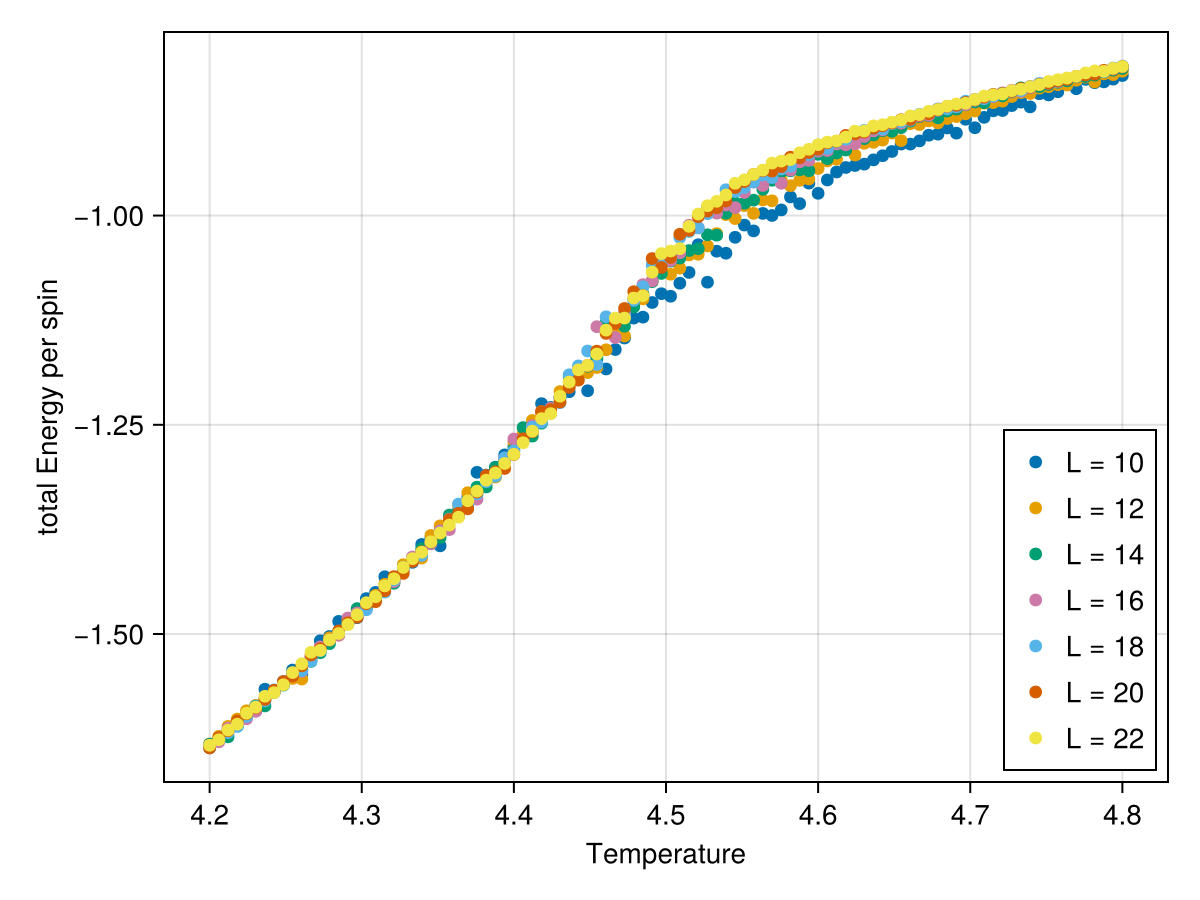

In [4]:
fig = Figure()
ax = Axis(fig[1,1], xlabel="Temperature", ylabel="total Energy per spin")
for (grid_size, energies_, temps_) in zip(grid_sizes, energies, temps)
    plot!(ax, temps_, energies_[1]./grid_size^3, label="L = $grid_size")
end
axislegend(ax, position=:rb)
fig

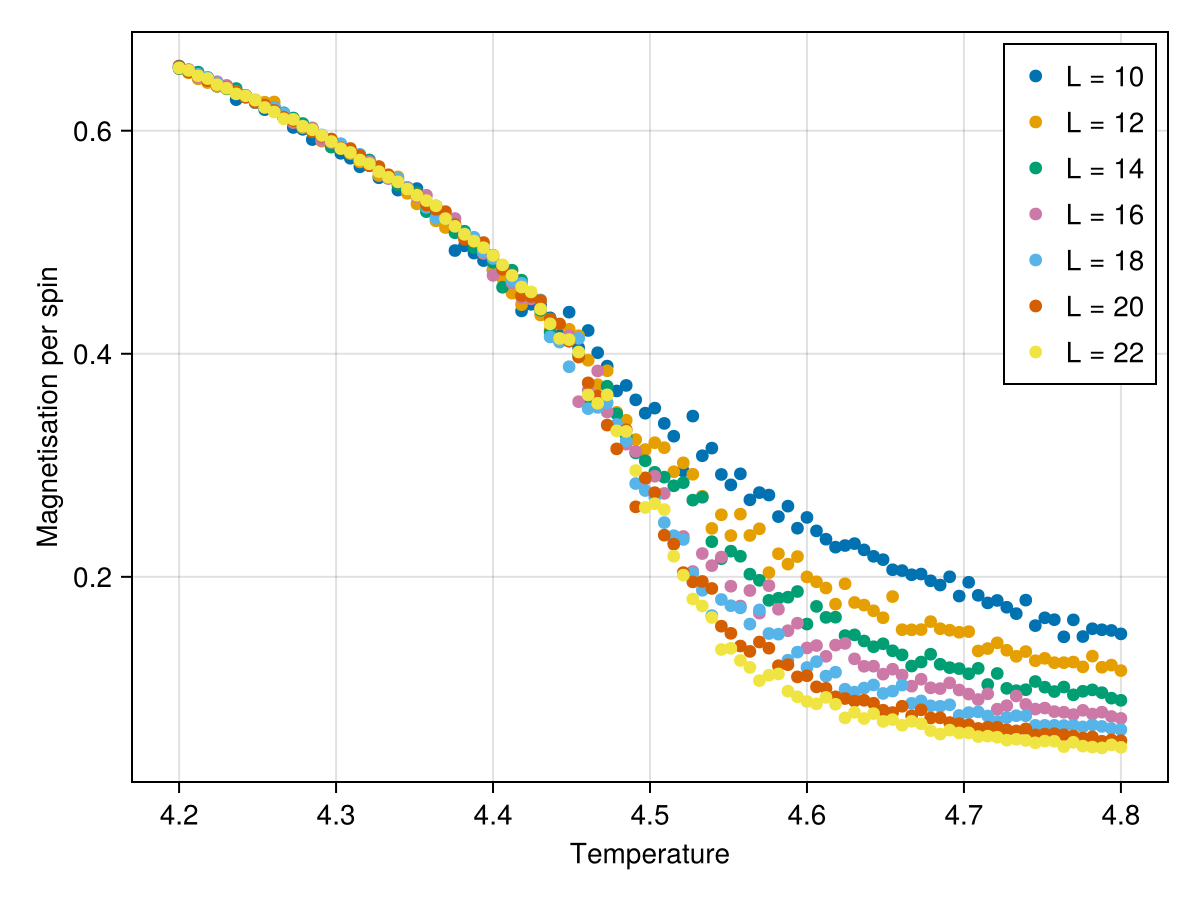

In [5]:
fig = Figure()
ax = Axis(fig[1,1], xlabel="Temperature", ylabel="Magnetisation per spin")
for (grid_size, magnetisations_, temps_) in zip(grid_sizes, magnetisations, temps)
    plot!(ax, temps_, abs.(magnetisations_[1]), label="L = $grid_size")
end
axislegend(ax, position=:rt)
fig

### calculate Binder Constant
$U_L(T) = 1 - \frac{\langle M^4 \rangle_L}{3 \langle M^2 \rangle^2_L}$

In [6]:
function binder_cum(mag_2::Float64, mag_4::Float64)
    return 1 - mag_4 / (3 * mag_2^2)
end

binder_cum (generic function with 1 method)

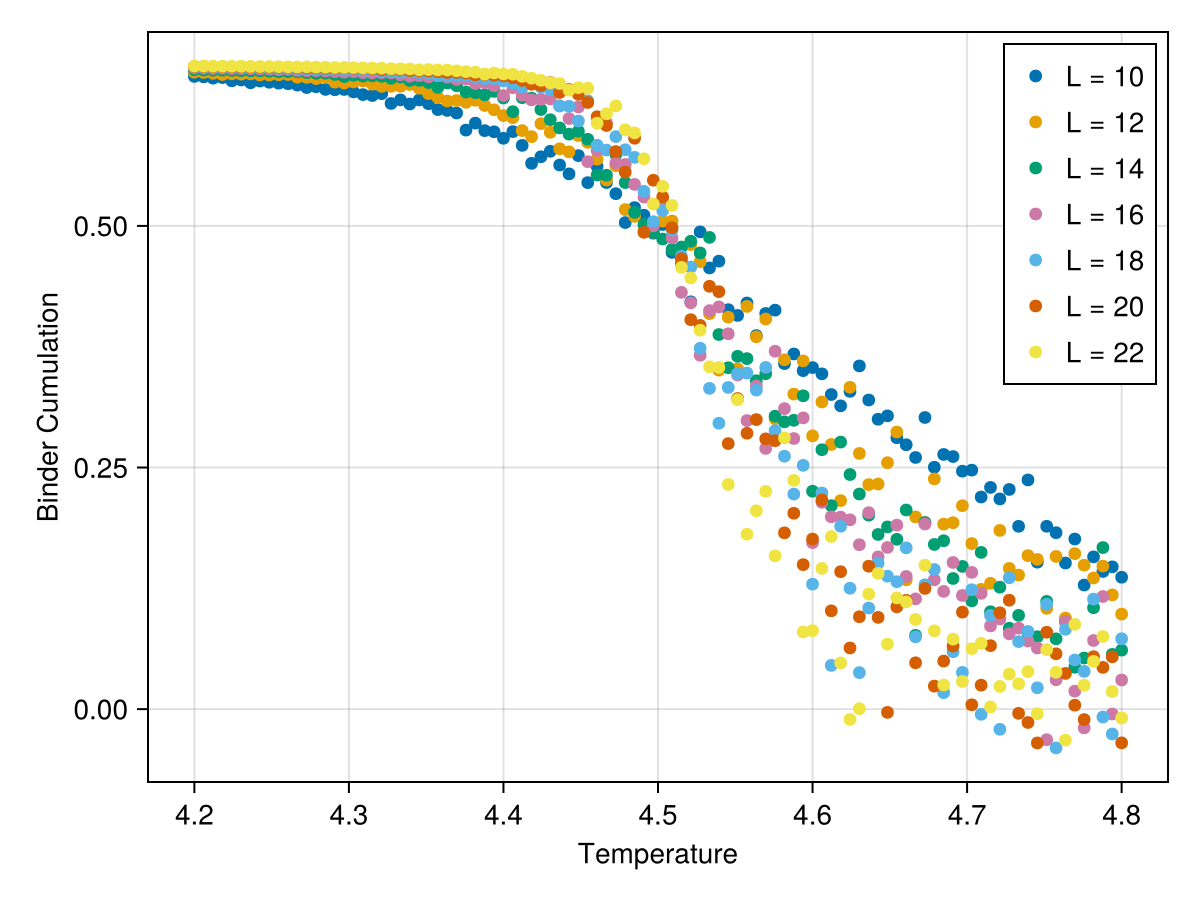

In [7]:
fig = Figure()
ax = Axis(fig[1,1], xlabel="Temperature", ylabel="Binder Cumulation")
# binder_cums = []
for (grid_size, magnetisations_, temps_) in zip(grid_sizes, magnetisations, temps)
    binder_cums_ = binder_cum.(magnetisations_[3],magnetisations_[4])

    # binder_cums_ = roll_avg(binder_cums_, w=10)

    # push!(binder_cums, binder_cums_)
    plot!(temps_, binder_cums_, label="L = $grid_size")
    
end
axislegend(ax, position=:rt)
fig

In [8]:
function roll_avg(x::Vector{Float64}; w::Int=10)
    for i in 1:length(x)
        x[i] = mean(@view x[max(1, i-w):min(end, i+w)])
    end
    return x
end

roll_avg (generic function with 1 method)

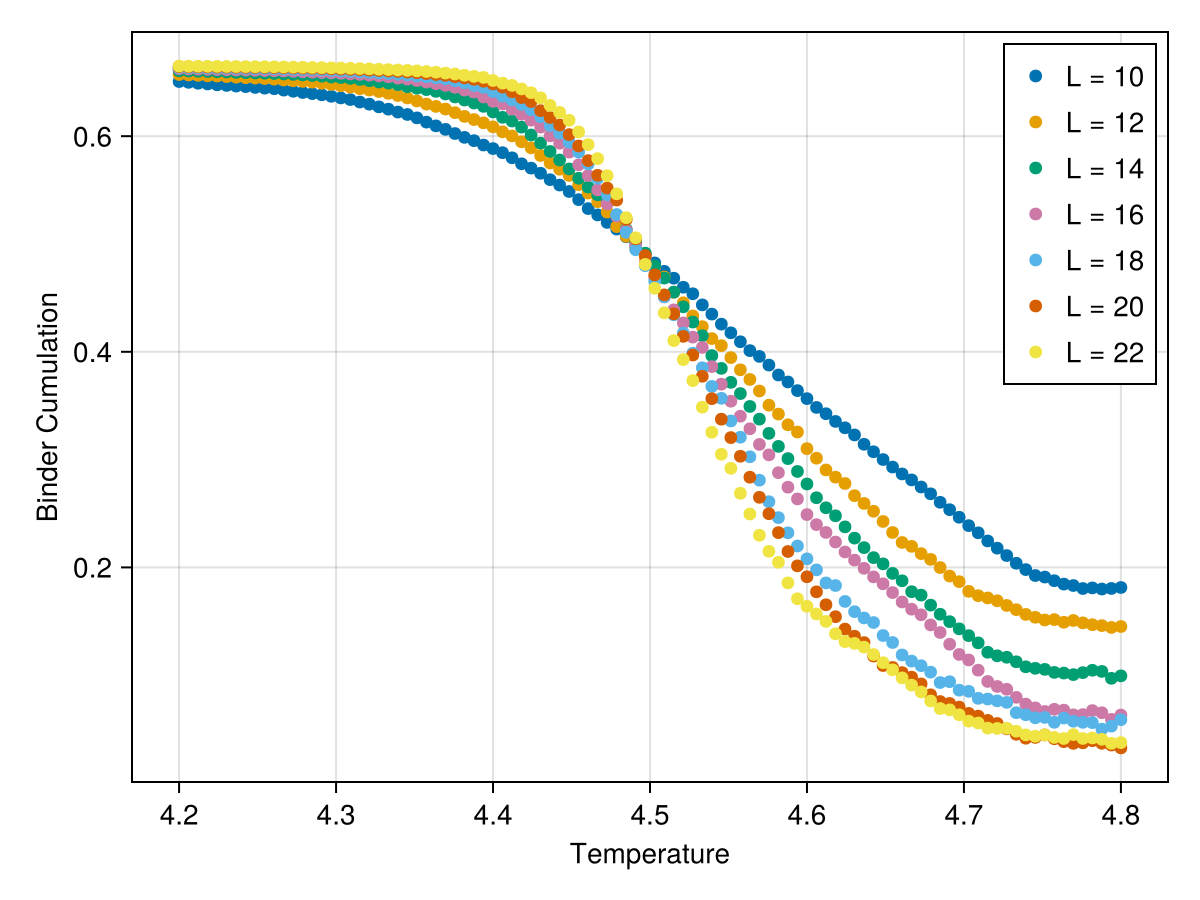

In [9]:
fig = Figure()
ax = Axis(fig[1,1], xlabel="Temperature", ylabel="Binder Cumulation")
binder_cums = []
for (grid_size, magnetisations_, temps_) in zip(grid_sizes, magnetisations, temps)
    binder_cums_ = binder_cum.(magnetisations_[3],magnetisations_[4])

    binder_cums_ = roll_avg(binder_cums_, w=10)

    push!(binder_cums, binder_cums_)
    plot!(temps_, binder_cums_, label="L = $grid_size")
    
end
axislegend(ax, position=:rt)
fig

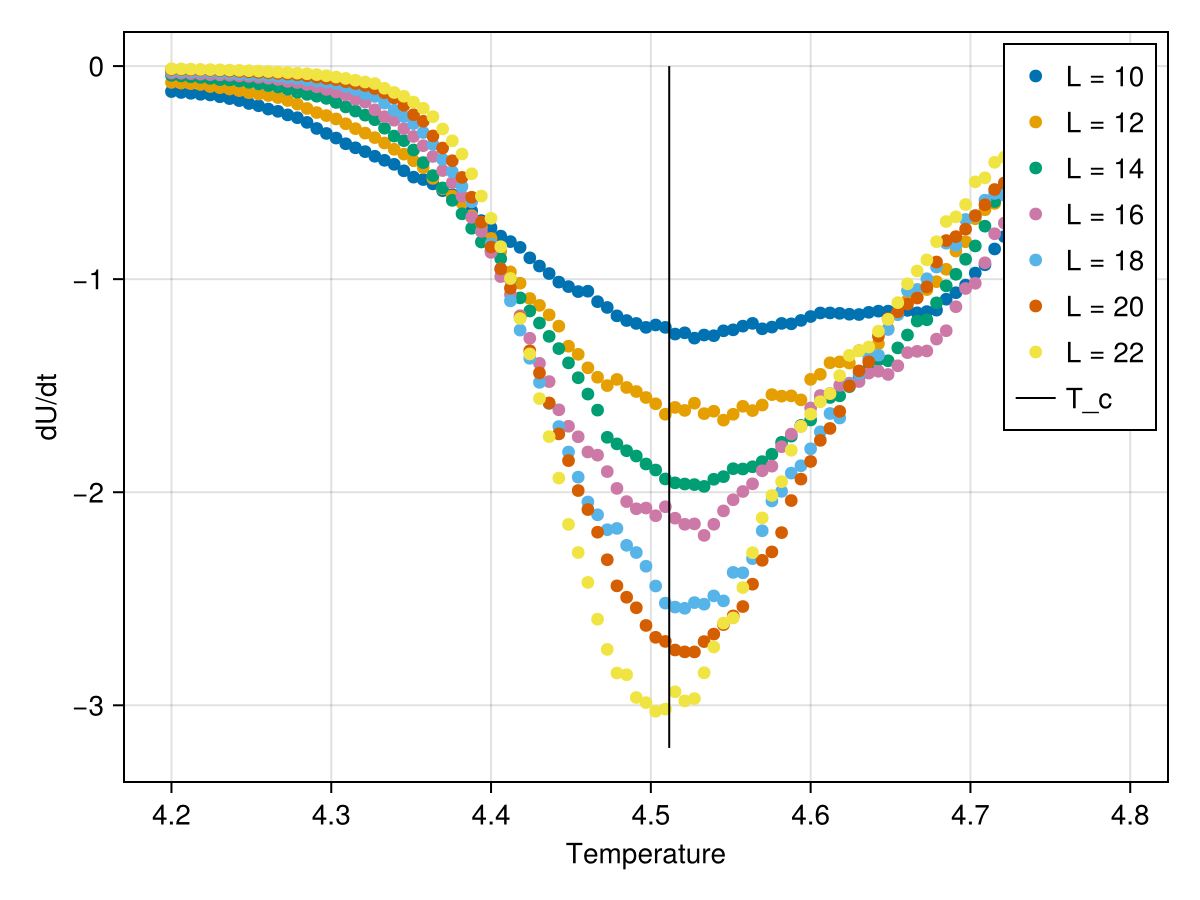

In [10]:
fig = Figure()
ax = Axis(fig[1,1], xlabel="Temperature", ylabel="dU/dt")
dU_dts = []
for (grid_size, binder_cums_, temps_) in zip(grid_sizes, binder_cums, temps)
    # derivative of binder cumulant
    dU_dt = diff(binder_cums_) ./ diff(temps_)
    dU_dt = roll_avg(dU_dt, w=10)
    
    push!(dU_dts, dU_dt)
    plot!(temps_[1:end-1], dU_dt, label="L = $grid_size")
end

# plot vertical line at critical temperature
lines!(ax, [T_c], [0, -3.2], color=:black, linewidth=1, label="T_c")
axislegend(ax, position=:rt)
fig

L = 10: T_C = 4.534560898501789
L = 12: T_C = 4.534260024213268
L = 14: T_C = 4.5248879949042395
L = 16: T_C = 4.513679184232883
L = 18: T_C = 4.51355414506694
L = 20: T_C = 4.513113917245887
L = 22: T_C = 4.500600117869155


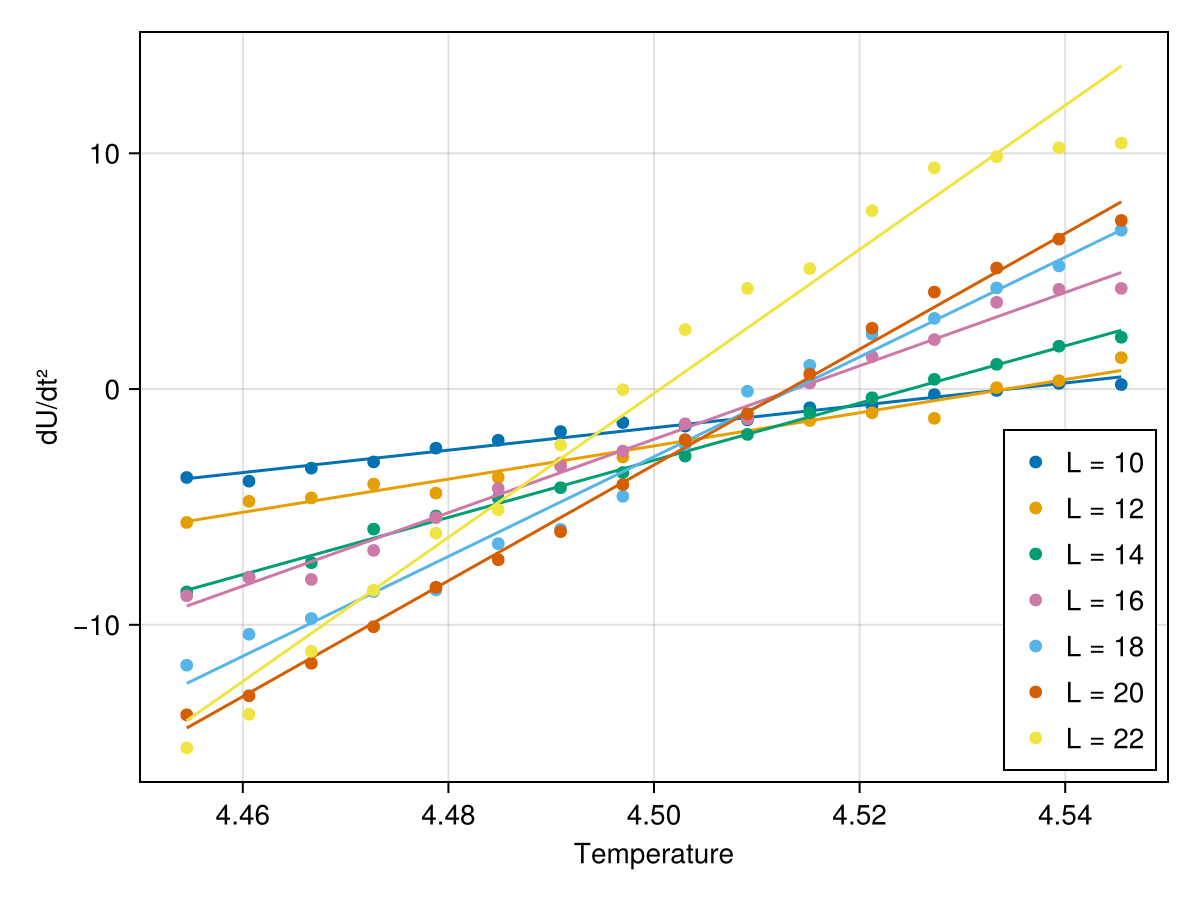

In [11]:
linfit(x, p) = x .* p[1] .+ p[2]

T_min, T_max = 4.45, 4.55

fig = Figure()
ax = Axis(fig[1,1], xlabel="Temperature", ylabel="dU/dt²")
for (grid_size, dU_dt, temps_) in zip(grid_sizes, dU_dts, temps)
    # derivative of binder cumulant
    dU_dt2 = diff(dU_dt) ./ diff(temps_[1:end-1])
    dU_dt2 = roll_avg(dU_dt2, w=10)

    t = temps_[1:end-2]

    dU_dt2 = dU_dt2[t .> T_min]
    t = t[t .> T_min]

    dU_dt2 = dU_dt2[t .< T_max]
    t = t[t .< T_max]
    
    plot!(t, dU_dt2, label="L = $grid_size")

    # fit
    fit = lsq.curve_fit(linfit, t, dU_dt2, [1.0, 1.0])
    lines!(t, linfit(t, fit.param))

    x_0 = -fit.param[2] / fit.param[1]
    println("L = $grid_size: T_C = $x_0")
end
# xlims!(ax, 4.45, 4.55)

# plot vertical line at critical temperature
# lines!(ax, [T_c], [-15, 15], color=:black, linewidth=2, label="T_c")
axislegend(ax, position=:rb)
fig